<a href="https://colab.research.google.com/github/BalytskyiJaroslaw/PathogensRamanOpenSet/blob/main/Naive_K_p_1_p_3_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive thresholding, $\mathcal{K} = p_1+p_3$, $\mathcal{I}$ = $∅$

In [ ]:
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
from numpy import genfromtxt
from sklearn.utils import shuffle


import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas import read_csv

from keras.layers import Lambda, Multiply
import csv
import pprint

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import keras
#from keras.utils import to_categorical
from pandas import read_csv
from keras.models import Sequential
from keras import layers
#from keras.optimizers import SGD
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
#from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint

from sklearn.preprocessing import LabelEncoder
import gspread
import pandas as pd
import pickle
import pywt
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
#from keras.utils import to_categorical

from time import time
t00 = time()
import os
from tensorflow.keras import layers
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from keras.layers import GlobalAveragePooling1D

# Initializing TPU

In [ ]:
# Initialize the TPU and spread the computations across the 8 cores
import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
tf.config.list_logical_devices('TPU')
#print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

# Uploading the data

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Reference dataset

In [ ]:
# Reference data
data_X_reference = np.load("/content/gdrive/MyDrive/Stanford_data/X_reference.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_reference = np.load("/content/gdrive/MyDrive/Stanford_data/y_reference.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_reference_int = []

for i in range(data_y_reference.shape[0]):
  data_y_reference_int.append(int(data_y_reference[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_reference_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

# The case of $\mathcal{K} = p_1+p_3$, corresponds to the known training reference indices: 10000 - 14000, 18000 - 28000, 34000 - 38000, 42000 - 50000, 56000 - 60000

In [ ]:
indices = [slice(10000, 14000),slice(18000, 28000),slice(34000, 38000),slice(42000, 50000),slice(56000, 60000)]

Known_data_X_reference = np.concatenate([data_X_reference[idx, :] for idx in indices], axis=0)

Known_data_X_train_label_int = []

for i in range(2000*15):
  Known_data_X_train_label_int.append(int(data_y_reference[i]))

Known_data_X_train_label = tf.keras.utils.to_categorical(Known_data_X_train_label_int)
print("Shape of the known data, reference:", Known_data_X_reference.shape)
print("Shape of the known labels, reference:", Known_data_X_train_label.shape)

Shape of the known data, reference: (30000, 1000)
Shape of the known labels, reference: (30000, 15)


# Known data indices, testing dataset. Indices = 500 - 700, 900 - 1400, 1700 - 1900, 2100 - 2500, 2800 - 3000

In [ ]:
indices = [slice(500, 700),slice(900, 1400),slice(1700, 1900),slice(2100, 2500),slice(2800, 3000)]

Known_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

Known_data_X_test_label_int = []

for i in range(100*15):
  Known_data_X_test_label_int.append(int(data_y_test[i]))

Known_data_X_test_label = tf.keras.utils.to_categorical(Known_data_X_test_label_int)
print("Shape of the known data, test:", Known_data_X_test.shape)
print("Shape of the known labels, test:", Known_data_X_test_label.shape)

Shape of the known data, test: (1500, 1000)
Shape of the known labels, test: (1500, 15)


# Never seen before, $\mathcal{N} = p_4$, test: 0 - 500, 700 - 900, 1900 - 2100, 2500 - 2600.


In [ ]:
indices = [slice(0, 500),slice(700, 900),slice(1900, 2100),slice(2500, 2600)]
NeverSeen_data_X_test = np.concatenate([data_X_test[idx, :] for idx in indices], axis=0)

NeverSeen_data_X_test_label_int = []

for i in range(100*10):
  NeverSeen_data_X_test_label_int.append(int(data_y_test[i]))

NeverSeen_data_X_test_label = tf.keras.utils.to_categorical(NeverSeen_data_X_test_label_int)
print("Shape of the Neverseen data, test:", NeverSeen_data_X_test.shape)
print("Shape of the Neverseen labels, test:", NeverSeen_data_X_test_label.shape)

Shape of the Neverseen data, test: (1000, 1000)
Shape of the Neverseen labels, test: (1000, 10)


# Finetuning dataset

In [ ]:
# Finetuning
data_X_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/X_finetune.npy")
# Test data
data_X_test = np.load("/content/gdrive/MyDrive/Stanford_data/X_test.npy")

data_y_finetune = np.load("/content/gdrive/MyDrive/Stanford_data/y_finetune.npy")
# Test labels
data_y_test = np.load("/content/gdrive/MyDrive/Stanford_data/y_test.npy")

data_y_finetune_int = []

for i in range(data_y_finetune.shape[0]):
  data_y_finetune_int.append(int(data_y_finetune[i]))

data_y_test_int = []

for i in range(data_y_test.shape[0]):
  data_y_test_int.append(int(data_y_test[i]))

train_label = tf.keras.utils.to_categorical(data_y_finetune_int)
test_label = tf.keras.utils.to_categorical(data_y_test_int)

#data_X_finetune, train_label = shuffle(data_X_finetune, train_label)

# Known data for finetuning. Finetuning indices = 500 - 700, 900 - 1400, 1700 - 1900, 2100 - 2500, 2800 - 3000


In [ ]:
indices = [slice(500, 700),slice(900, 1400),slice(1700, 1900),slice(2100, 2500),slice(2800, 3000)]

Known_data_X_finetune = np.concatenate([data_X_finetune[idx, :] for idx in indices], axis=0)

Known_data_X_finetune_label_int = []

for i in range(100*15):
  Known_data_X_finetune_label_int.append(int(data_y_finetune[i]))

Known_data_X_finetune_label = tf.keras.utils.to_categorical(Known_data_X_finetune_label_int)

print("Shape of the known data, finetune:", Known_data_X_finetune.shape)
print("Shape of the known labels, finetune:", Known_data_X_finetune_label.shape)

Shape of the known data, finetune: (1500, 1000)
Shape of the known labels, finetune: (1500, 15)


# Initializing the our NN

In [ ]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

import numpy as np
import pandas as pd
import seaborn as sns
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from sklearn.metrics import mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, classification_report, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, concatenate, BatchNormalization, Activation, add
from keras.layers import Conv2D, MaxPooling2D, Reshape, Flatten, Dense, GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Conv1DTranspose, LeakyReLU, Dropout
from keras.models import Model, model_from_json
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
sns.set_theme(style="whitegrid")

In [ ]:
# Constants
NoF = 64  # Number of filters in the first convolutional layer
SE_RATIO = 16  # Squeeze-and-Excitation ratio

nb_classes = 15


initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)

def squeeze_excitation_block(X, ratio=16):
    num_channels = X.shape[-1]
    se = tf.keras.layers.GlobalAveragePooling1D()(X)
    se = tf.keras.layers.Reshape((1, num_channels))(se)
    se = tf.keras.layers.Dense(num_channels // ratio, activation='relu', kernel_initializer=initializer)(se)
    se = tf.keras.layers.Dense(num_channels, activation='sigmoid', kernel_initializer=initializer)(se)
    return tf.keras.layers.Multiply()([X, se])


from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Add
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers

initializer = tf.keras.initializers.GlorotUniform(seed=0)
initializer2 = tf.keras.initializers.HeUniform(seed=0)
Stride=1

def identity_block(X, f, filters, stage, block):

  #defining name basis
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'bn' + str(stage) + block + '_branch'

  #retrieve filters
  F1,F2,F3 = filters

  #save the input value. You'll need this later to add back the main path
  x_shortcut = X

  ### First component of the main path ###
  X = tf.keras.layers.Conv1D(filters=F1, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  ### Second component of main path ###
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, #name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third Component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=1, strides=Stride, padding='same',
             kernel_initializer=initializer#,name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)

  #Final step: add shortcut to the main path, and pass it through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def convolutional_block(X, f, filters, stage, block, s=2):

  #Defining name bases
  ConvNameBase = 'res' + str(stage) + block + '_branch'
  BatchNormBase = 'res' + str(stage) + block + '_branch'

  #retrive n_filters
  F1, F2, F3 = filters

  #Save the input value
  x_shortcut = X

  #First component of the main path
  X = tf.keras.layers.Conv1D(F1, strides=s, kernel_size=f, kernel_initializer=initializer,
             padding='same'#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Second Component of main path
  X = tf.keras.layers.Conv1D(filters=F2, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer#, name=ConvNameBase
             )(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                         )(X)
  X = tf.keras.layers.Activation('relu')(X)

  #Third component of main path
  X = tf.keras.layers.Conv1D(filters=F3, kernel_size=f, strides=Stride, padding='same',
             kernel_initializer=initializer, name=ConvNameBase)(X)
  X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
  )(X)

  ###### SHORTCUT PATH ######
  x_shortcut = tf.keras.layers.Conv1D(filters = F3, kernel_size=1, strides=s,
                      padding='same', #name=ConvNameBase,
                      kernel_initializer=initializer)(x_shortcut)
  x_shortcut = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,
                                  )(x_shortcut)

  #Add shortcut to main path and pass in through ReLU activation
  X = tf.keras.layers.Add()([X, x_shortcut])
  X = tf.keras.layers.Activation('relu')(X)

  return X

def create_model():
    input_shape = (1000, 1)

    x_input = tf.keras.layers.Input(input_shape)
    X = tf.keras.layers.ZeroPadding1D(padding=3)(x_input)

    X = tf.keras.layers.Conv1D(NoF, kernel_size=7, strides=2, name='Convolution1',
                               kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(name="BatchNormStage1")(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling1D(3, strides=2)(X)

    X = convolutional_block(X, f=3, filters=[NoF, NoF, NoF * 4], stage=2, block='a', s=1)
    X = identity_block(X, 3, [NoF, NoF, NoF * 4], stage=2, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 2, NoF * 2, NoF * 8], stage=3, block='a')
    X = identity_block(X, 3, [NoF * 2, NoF * 2, NoF * 8], stage=3, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 16], stage=4, block='a')
    X = identity_block(X, 3, [NoF * 4, NoF * 4, NoF * 16], stage=4, block='b')

    X = convolutional_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='a')
    X = identity_block(X, f=3, filters=[NoF * 4, NoF * 4, NoF * 32], stage=5, block='b')

    # Applying SE mechanism before transposed convolutional layers
    X = squeeze_excitation_block(X)

    # Adding transposed convolutional layers
    X = Conv1DTranspose(filters=NoF, kernel_size=3, strides=2, padding='same', kernel_initializer=initializer)(X)
    X = tf.keras.layers.BatchNormalization(axis=2, momentum=0.99, trainable=False,)(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)

    # Adding dropout regularization
    X = Dropout(0.5)(X)

    X = Dense(nb_classes, activation='softmax', kernel_initializer=initializer)(X)

    res_net = models.Model(inputs=x_input, outputs=X, name='ResNet29')

    return res_net

model = create_model()
model.summary()

Model: "ResNet29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1000, 1)]            0         []                            
                                                                                                  
 zero_padding1d (ZeroPaddin  (None, 1006, 1)              0         ['input_1[0][0]']             
 g1D)                                                                                             
                                                                                                  
 Convolution1 (Conv1D)       (None, 500, 64)              512       ['zero_padding1d[0][0]']      
                                                                                                  
 BatchNormStage1 (BatchNorm  (None, 500, 64)              256       ['Convolution1[0][0]'] 

In [ ]:
with strategy.scope():
  res_net = create_model()
  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=10, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
             metrics=['accuracy'])

  Known_data_X_reference, Known_data_X_train_label = shuffle(Known_data_X_reference, Known_data_X_train_label)

  history = res_net.fit(Known_data_X_reference, Known_data_X_train_label, epochs=200, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  test_loss, test_acc = res_net.evaluate(Known_data_X_test, Known_data_X_test_label)

  print('Test accuracy, 01_SJ11:', test_acc)

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p3.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)

47/47 [==============================] - 41s 781ms/step - loss: 3.3412 - accuracy: 0.5160
Test accuracy, 01 run: 0.515999972820282
47/47 [==============================] - 71s 1s/step - loss: 3.9487 - accuracy: 0.5473
Test accuracy, 02 run: 0.5473333597183228
47/47 [==============================] - 49s 871ms/step - loss: 3.5961 - accuracy: 0.5113
Test accuracy, 03 run: 0.5113333463668823
47/47 [==============================] - 36s 724ms/step - loss: 3.3539 - accuracy: 0.5347
Test accuracy, 04 run: 0.5346666574478149
47/47 [==============================] - 43s 870ms/step - loss: 3.6036 - accuracy: 0.5387
Test accuracy, 05 run: 0.5386666655540466
47/47 [==============================] - 38s 767ms/step - loss: 3.2325 - accuracy: 0.5413
Test accuracy, 06 run: 0.5413333177566528
47/47 [==============================] - 42s 831ms/step - loss: 3.6076 - accuracy: 0.5380
Test accuracy, 07 run: 0.5379999876022339
47/47 [==============================] - 38s 775ms/step - loss: 3.3121 - accurac

In [ ]:
with strategy.scope():
  res_net = create_model()

  optimizer = tf.keras.optimizers.Adam()
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=res_net)
  callbacks = [EarlyStopping(monitor='val_loss', patience=30, mode='min'), ModelCheckpoint('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3_FTm3.h5', verbose=1, monitor='val_loss', save_best_only=True, mode='min')]
  res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
             metrics=['accuracy'])

  res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3.h5")

  for layer in res_net.layers[:-3]:
    layer.trainable = False

  Known_data_X_finetune, Known_data_X_finetune_label = shuffle(Known_data_X_finetune, Known_data_X_finetune_label)

  history = res_net.fit(Known_data_X_finetune, Known_data_X_finetune_label, epochs=1500, batch_size=32, verbose=1, validation_split=0.2, shuffle=True, callbacks=callbacks)

  res_net.save_weights('/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3_FTm3_PP.h5')

  test_loss, test_acc = res_net.evaluate(Known_data_X_test, Known_data_X_test_label)
  print('Test accuracy, 01 run, after finetuning:', test_acc)

Streaming output truncated to the last 5000 lines.
Epoch 26/1500
37/38 [============================>.] - ETA: 0s - loss: 0.4116 - accuracy: 0.8590
Epoch 26: val_loss improved from 0.34326 to 0.33415, saving model to /content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p3_FTm3.h5
38/38 [==============================] - 5s 121ms/step - loss: 0.4095 - accuracy: 0.8592 - val_loss: 0.3342 - val_accuracy: 0.8767
Epoch 27/1500
38/38 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8692
Epoch 27: val_loss did not improve from 0.33415
38/38 [==============================] - 2s 60ms/step - loss: 0.4166 - accuracy: 0.8692 - val_loss: 0.3392 - val_accuracy: 0.8867
Epoch 28/1500
38/38 [==============================] - ETA: 0s - loss: 0.3820 - accuracy: 0.8733
Epoch 28: val_loss improved from 0.33415 to 0.32376, saving model to /content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p3_FTm3.h5
38/38 [==============================] - 5s 126ms/step - loss: 0.3820 - accuracy: 0.8

In [ ]:
# Now run and see the models with the best validation accuracy

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 01 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 02 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 03 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 04 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 05 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 06 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 07 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 08 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 09 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 10 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 11 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 12 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 13 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 14 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 15 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 16 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 17 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 18 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 19 run:', test_acc)

res_net = create_model()
res_net.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p3_FTm3_PP.h5")
res_net.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=.00001/10),
            metrics=['accuracy'])
test_loss, test_acc = res_net.evaluate(Known_data_X_test,Known_data_X_test_label)
print('Test accuracy, 20 run:', test_acc)

47/47 [==============================] - 33s 636ms/step - loss: 0.5455 - accuracy: 0.8720
Test accuracy, 01 run: 0.871999979019165
47/47 [==============================] - 32s 650ms/step - loss: 0.5801 - accuracy: 0.8687
Test accuracy, 02 run: 0.8686666488647461
47/47 [==============================] - 33s 643ms/step - loss: 0.5115 - accuracy: 0.8813
Test accuracy, 03 run: 0.8813333511352539
47/47 [==============================] - 33s 648ms/step - loss: 0.5512 - accuracy: 0.8700
Test accuracy, 04 run: 0.8700000047683716
47/47 [==============================] - 32s 646ms/step - loss: 0.5354 - accuracy: 0.8820
Test accuracy, 05 run: 0.8820000290870667
47/47 [==============================] - 33s 645ms/step - loss: 0.5390 - accuracy: 0.8787
Test accuracy, 06 run: 0.8786666393280029
47/47 [==============================] - 33s 669ms/step - loss: 0.6348 - accuracy: 0.8687
Test accuracy, 07 run: 0.8686666488647461
47/47 [==============================] - 33s 664ms/step - loss: 0.5219 - accu

# Combine the models into ensemble

In [ ]:
res_net01 = create_model()
res_net02 = create_model()
res_net03 = create_model()
res_net04 = create_model()
res_net05 = create_model()
res_net06 = create_model()
res_net07 = create_model()
res_net08 = create_model()
res_net09 = create_model()
res_net10 = create_model()
res_net11 = create_model()
res_net12 = create_model()
res_net13 = create_model()
res_net14 = create_model()
res_net15 = create_model()
res_net16 = create_model()
res_net17 = create_model()
res_net18 = create_model()
res_net19 = create_model()
res_net20 = create_model()

res_net01.load_weights("/content/gdrive/MyDrive/Stanford_data/01_Naive_K_p1_p3_FTm3_PP.h5")
res_net02.load_weights("/content/gdrive/MyDrive/Stanford_data/02_Naive_K_p1_p3_FTm3_PP.h5")
res_net03.load_weights("/content/gdrive/MyDrive/Stanford_data/03_Naive_K_p1_p3_FTm3_PP.h5")
res_net04.load_weights("/content/gdrive/MyDrive/Stanford_data/04_Naive_K_p1_p3_FTm3_PP.h5")
res_net05.load_weights("/content/gdrive/MyDrive/Stanford_data/05_Naive_K_p1_p3_FTm3_PP.h5")
res_net06.load_weights("/content/gdrive/MyDrive/Stanford_data/06_Naive_K_p1_p3_FTm3_PP.h5")
res_net07.load_weights("/content/gdrive/MyDrive/Stanford_data/07_Naive_K_p1_p3_FTm3_PP.h5")
res_net08.load_weights("/content/gdrive/MyDrive/Stanford_data/08_Naive_K_p1_p3_FTm3_PP.h5")
res_net09.load_weights("/content/gdrive/MyDrive/Stanford_data/09_Naive_K_p1_p3_FTm3_PP.h5")
res_net10.load_weights("/content/gdrive/MyDrive/Stanford_data/10_Naive_K_p1_p3_FTm3_PP.h5")
res_net11.load_weights("/content/gdrive/MyDrive/Stanford_data/11_Naive_K_p1_p3_FTm3_PP.h5")
res_net12.load_weights("/content/gdrive/MyDrive/Stanford_data/12_Naive_K_p1_p3_FTm3_PP.h5")
res_net13.load_weights("/content/gdrive/MyDrive/Stanford_data/13_Naive_K_p1_p3_FTm3_PP.h5")
res_net14.load_weights("/content/gdrive/MyDrive/Stanford_data/14_Naive_K_p1_p3_FTm3_PP.h5")
res_net15.load_weights("/content/gdrive/MyDrive/Stanford_data/15_Naive_K_p1_p3_FTm3_PP.h5")
res_net16.load_weights("/content/gdrive/MyDrive/Stanford_data/16_Naive_K_p1_p3_FTm3_PP.h5")
res_net17.load_weights("/content/gdrive/MyDrive/Stanford_data/17_Naive_K_p1_p3_FTm3_PP.h5")
res_net18.load_weights("/content/gdrive/MyDrive/Stanford_data/18_Naive_K_p1_p3_FTm3_PP.h5")
res_net19.load_weights("/content/gdrive/MyDrive/Stanford_data/19_Naive_K_p1_p3_FTm3_PP.h5")
res_net20.load_weights("/content/gdrive/MyDrive/Stanford_data/20_Naive_K_p1_p3_FTm3_PP.h5")



prediction01_known = res_net01.predict(Known_data_X_test)
prediction02_known = res_net02.predict(Known_data_X_test)
prediction03_known = res_net03.predict(Known_data_X_test)
prediction04_known = res_net04.predict(Known_data_X_test)
prediction05_known = res_net05.predict(Known_data_X_test)
prediction06_known = res_net06.predict(Known_data_X_test)
prediction07_known = res_net07.predict(Known_data_X_test)
prediction08_known = res_net08.predict(Known_data_X_test)
prediction09_known = res_net09.predict(Known_data_X_test)
prediction10_known = res_net10.predict(Known_data_X_test)

prediction11_known = res_net11.predict(Known_data_X_test)
prediction12_known = res_net12.predict(Known_data_X_test)
prediction13_known = res_net13.predict(Known_data_X_test)
prediction14_known = res_net14.predict(Known_data_X_test)
prediction15_known = res_net15.predict(Known_data_X_test)
prediction16_known = res_net16.predict(Known_data_X_test)
prediction17_known = res_net17.predict(Known_data_X_test)
prediction18_known = res_net18.predict(Known_data_X_test)
prediction19_known = res_net19.predict(Known_data_X_test)
prediction20_known = res_net20.predict(Known_data_X_test)


prediction_known_ensemble_1 = (prediction01_known + prediction02_known + prediction03_known + prediction04_known + prediction05_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_1.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the first ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_2 = (prediction06_known + prediction07_known + prediction08_known + prediction09_known + prediction10_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_2.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the second ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_3 = (prediction11_known + prediction12_known + prediction13_known + prediction14_known + prediction15_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_3.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the third ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

prediction_known_ensemble_4 = (prediction16_known + prediction17_known + prediction18_known + prediction19_known + prediction20_known)/5

true = 0
for i in range(Known_data_X_test_label.shape[0]):
  if prediction_known_ensemble_4.argmax(axis=1)[i] == Known_data_X_test_label_int[i]:
    true += 1
print("Accuracy of the fourth ensemble on the knowns", true/(Known_data_X_test_label.shape[0]))

47/47 [==============================] - 10s 184ms/step
Accuracy of the first ensemble on the knowns 0.8833333333333333
Accuracy of the second ensemble on the knowns 0.88
Accuracy of the third ensemble on the knowns 0.8786666666666667
Accuracy of the fourth ensemble on the knowns 0.8793333333333333


In [ ]:
prediction01_unknown = res_net01.predict(NeverSeen_data_X_test)
prediction02_unknown = res_net02.predict(NeverSeen_data_X_test)
prediction03_unknown = res_net03.predict(NeverSeen_data_X_test)
prediction04_unknown = res_net04.predict(NeverSeen_data_X_test)
prediction05_unknown = res_net05.predict(NeverSeen_data_X_test)
prediction06_unknown = res_net06.predict(NeverSeen_data_X_test)
prediction07_unknown = res_net07.predict(NeverSeen_data_X_test)
prediction08_unknown = res_net08.predict(NeverSeen_data_X_test)
prediction09_unknown = res_net09.predict(NeverSeen_data_X_test)
prediction10_unknown = res_net10.predict(NeverSeen_data_X_test)
prediction11_unknown = res_net11.predict(NeverSeen_data_X_test)
prediction12_unknown = res_net12.predict(NeverSeen_data_X_test)
prediction13_unknown = res_net13.predict(NeverSeen_data_X_test)
prediction14_unknown = res_net14.predict(NeverSeen_data_X_test)
prediction15_unknown = res_net15.predict(NeverSeen_data_X_test)
prediction16_unknown = res_net16.predict(NeverSeen_data_X_test)
prediction17_unknown = res_net17.predict(NeverSeen_data_X_test)
prediction18_unknown = res_net18.predict(NeverSeen_data_X_test)
prediction19_unknown = res_net19.predict(NeverSeen_data_X_test)
prediction20_unknown = res_net20.predict(NeverSeen_data_X_test)


prediction_unknown_ensemble_1 = (prediction01_unknown + prediction02_unknown + prediction03_unknown + prediction04_unknown + prediction05_unknown)/5
prediction_unknown_ensemble_2 = (prediction06_unknown + prediction07_unknown + prediction08_unknown + prediction09_unknown + prediction10_unknown)/5
prediction_unknown_ensemble_3 = (prediction11_unknown + prediction12_unknown + prediction13_unknown + prediction14_unknown + prediction15_unknown)/5
prediction_unknown_ensemble_4 = (prediction16_unknown + prediction17_unknown + prediction18_unknown + prediction19_unknown + prediction20_unknown)/5

32/32 [==============================] - 6s 172ms/step


# ODIN scores

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_UN_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_UN_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_UN_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, UN_Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores

In [ ]:
import os

all_odin_scores = []
for scores in odin_scores_for_models:
    all_odin_scores.extend(scores)

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "all_odin_scores_NAIVEKp1p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in all_odin_scores:
        file.write(f"{score}\n")

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001
batch_size = 32
threshold = 0.1

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

odin_scores_for_models = [np.array([]) for _ in loaded_models]

def compute_odin_scores_for_model(model, images, threshold):
    logits_layer = model.layers[-2].output
    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    odin_scores_KNOWN = []

    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            output = logits_model(batch)
        grads = tape.gradient(output, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
        odin_scores_batch = max_logits - max_perturbed_softmax_scores

        odin_scores_KNOWN.extend(odin_scores_batch)

    return np.array(odin_scores_KNOWN)

for model_index, model in enumerate(loaded_models):
    odin_scores = compute_odin_scores_for_model(model, Known_data_X_test_as_tensor, threshold)
    odin_scores_for_models[model_index] = odin_scores


In [ ]:
import os

all_odin_scores = []
for scores in odin_scores_for_models:
    all_odin_scores.extend(scores)

folder_path = "/content/gdrive/MyDrive/Stanford_data"

file_name = "KNOWN_all_odin_scores_NAIVEKp1p3.txt"

file_path = os.path.join(folder_path, file_name)

with open(file_path, 'w') as file:
    for score in all_odin_scores:
        file.write(f"{score}\n")

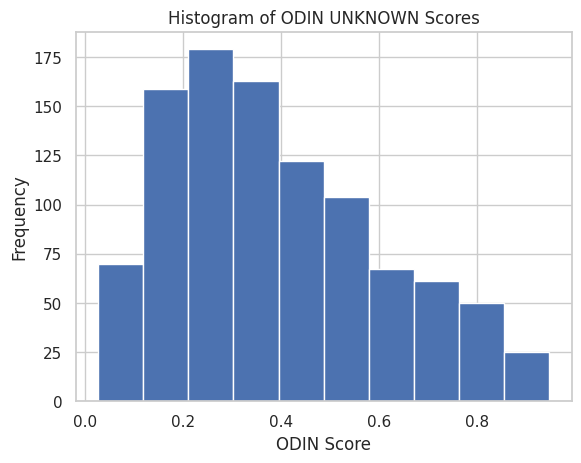

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

temperature = 1000
magnitude = 0.001

UN_Known_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

logits_layer = res_net01.layers[-2].output
logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

odin_scores_UN_KNOWN = []

batch_size = 32

for i in range(0, len(NeverSeen_data_X_test), batch_size):
    batch = UN_Known_data_X_test_as_tensor[i:i+batch_size]

    with tf.device("/CPU:0"):
        logits = logits_model(batch)

    with tf.GradientTape() as tape:
        tape.watch(batch)
        output = logits_model(batch)
    grads = tape.gradient(output, batch)

    signed_grads = tf.sign(grads)

    perturbed_spectra = batch + magnitude * signed_grads

    with tf.device("/CPU:0"):
        perturbed_logits = logits_model(perturbed_spectra)

    scaled_perturbed_logits = perturbed_logits / temperature

    perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

    max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

    max_logits = tf.reduce_max(tf.nn.softmax(logits), axis=1)
    odin_scores_batch = max_logits - max_perturbed_softmax_scores

    odin_scores_UN_KNOWN.extend(odin_scores_batch)

odin_scores_UN_KNOWN = np.array(odin_scores_UN_KNOWN)

plt.hist(odin_scores_UN_KNOWN, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN UNKNOWN Scores')

plt.show()


In [ ]:
min(odin_scores_UN_KNOWN)

0.027058257

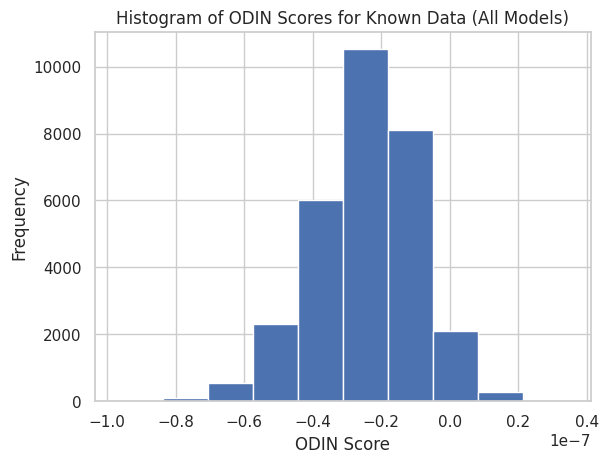

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
magnitude = 0.001
temperature = 1000
num_models = 20

loaded_models = [
    res_net01, res_net02, res_net03, res_net04, res_net05,
    res_net06, res_net07, res_net08, res_net09, res_net10,
    res_net11, res_net12, res_net13, res_net14, res_net15,
    res_net16, res_net17, res_net18, res_net19, res_net20
]

odin_scores_all_models = []

for i in range(num_models):
    logits_layer = loaded_models[i].layers[-2].output

    logits_model = tf.keras.Model(inputs=loaded_models[i].input, outputs=logits_layer)

    Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)

    odin_scores_KNOWN = []

    for j in range(0, len(Known_data_X_test), batch_size):
        batch = Known_data_X_test_as_tensor[j:j+batch_size]

        with tf.device("/CPU:0"):
            logits = logits_model(batch)

        with tf.GradientTape() as tape:
            tape.watch(batch)
            logits = logits_model(batch)
        grads = tape.gradient(logits, batch)

        signed_grads = tf.sign(grads)

        perturbed_spectra = batch + magnitude * signed_grads

        with tf.device("/CPU:0"):
            perturbed_logits = logits_model(perturbed_spectra)

        scaled_perturbed_logits = perturbed_logits / temperature

        perturbed_softmax_output = tf.nn.softmax(scaled_perturbed_logits)

        max_perturbed_softmax_scores = tf.reduce_max(perturbed_softmax_output, axis=1)

        original_softmax_output = tf.nn.softmax(logits / temperature)
        max_softmax_scores = tf.reduce_max(original_softmax_output, axis=1)

        odin_scores_batch = max_softmax_scores - max_perturbed_softmax_scores

        odin_scores_KNOWN.extend(odin_scores_batch)

    odin_scores_KNOWN = np.array(odin_scores_KNOWN)
    odin_scores_all_models.append(odin_scores_KNOWN)

combined_odin_scores = np.concatenate(odin_scores_all_models)

plt.hist(combined_odin_scores, bins=10)

plt.xlabel('ODIN Score')
plt.ylabel('Frequency')
plt.title('Histogram of ODIN Scores for Known Data (All Models)')

plt.show()

In [ ]:
import os

folder_path = "/content/gdrive/MyDrive/Stanford_data"
file_name = "KNOWN_all_odin_scores_NAIVEKp1p3.txt"
file_path = os.path.join(folder_path, file_name)
np.savetxt(file_path, combined_odin_scores, delimiter=',')


32/32 [==============================] - 7s 193ms/step
Condition Number of Covariance Matrix (Known Data): 253.25168256197594
32/32 [==============================] - 7s 176ms/step
Condition Number of Covariance Matrix (Known Data): 228.70166800074475
32/32 [==============================] - 7s 186ms/step
Condition Number of Covariance Matrix (Known Data): 241.09720677004123
32/32 [==============================] - 7s 172ms/step
Condition Number of Covariance Matrix (Known Data): 242.7929371321592
32/32 [==============================] - 7s 177ms/step
Condition Number of Covariance Matrix (Known Data): 211.6374411275592
32/32 [==============================] - 7s 173ms/step
Condition Number of Covariance Matrix (Known Data): 238.8628260430703
32/32 [==============================] - 8s 184ms/step
Condition Number of Covariance Matrix (Known Data): 227.21824548298287
32/32 [==============================] - 7s 179ms/step
Condition Number of Covariance Matrix (Known Data): 245.7282801098

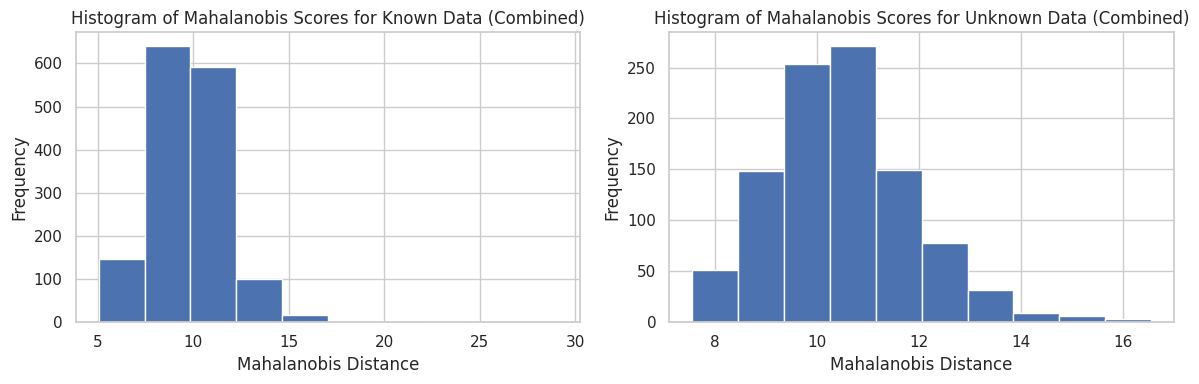

In [ ]:
import numpy as np
from scipy.spatial import distance
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# All loaded models
loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

deep_features_known_all = []
mahalanobis_distances_known_all = []
deep_features_unknown_all = []
mahalanobis_distances_unknown_all = []

# Number of PCA components to regularize the Mahalanobis matrix
n_components = 100

for model in loaded_models:
    deep_features_known = extract_deep_features(model, Known_data_X_test)
    deep_features_unknown = extract_deep_features(model, NeverSeen_data_X_test)

    # PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    deep_features_known_pca = pca.fit_transform(deep_features_known)
    deep_features_unknown_pca = pca.transform(deep_features_unknown)

    mean_known = np.mean(deep_features_known_pca, axis=0)
    cov_known = np.cov(deep_features_known_pca, rowvar=False)

    cond_number = np.linalg.cond(cov_known)
    print("Condition Number of Covariance Matrix (Known Data):", cond_number)

    # Regularization parameter
    epsilon = 1e-5

    if cond_number > 1 / epsilon:
        cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
    else:
        cov_known_reg = cov_known

    # Compute Mahalanobis distances for known and unknown deep features
    mahalanobis_distances_known = []
    for feature in deep_features_known_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_known.append(mahalanobis_distance)

    mahalanobis_distances_unknown = []
    for feature in deep_features_unknown_pca:
        mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
        mahalanobis_distances_unknown.append(mahalanobis_distance)

    deep_features_known_all.append(deep_features_known_pca)
    mahalanobis_distances_known_all.append(mahalanobis_distances_known)
    deep_features_unknown_all.append(deep_features_unknown_pca)
    mahalanobis_distances_unknown_all.append(mahalanobis_distances_unknown)

deep_features_known_combined = np.concatenate(deep_features_known_all, axis=-1)
mahalanobis_distances_known_combined = np.mean(mahalanobis_distances_known_all, axis=0)

deep_features_unknown_combined = np.concatenate(deep_features_unknown_all, axis=-1)
mahalanobis_distances_unknown_combined = np.mean(mahalanobis_distances_unknown_all, axis=0)

threshold_known = 3.0
threshold_unknown = 4.0

ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known_combined) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown_combined) if distance > threshold_unknown]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Known Data (Combined)')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown_combined, bins=10)
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Mahalanobis Scores for Unknown Data (Combined)')

plt.tight_layout()
plt.show()


In [ ]:
np.savetxt(f'{folder_path}/mahalanobis_distances_known_combined_Naivep1p3.txt', mahalanobis_distances_known_combined)
np.savetxt(f'{folder_path}/mahalanobis_distances_unknown_combined_Naivep1p3.txt', mahalanobis_distances_unknown_combined)

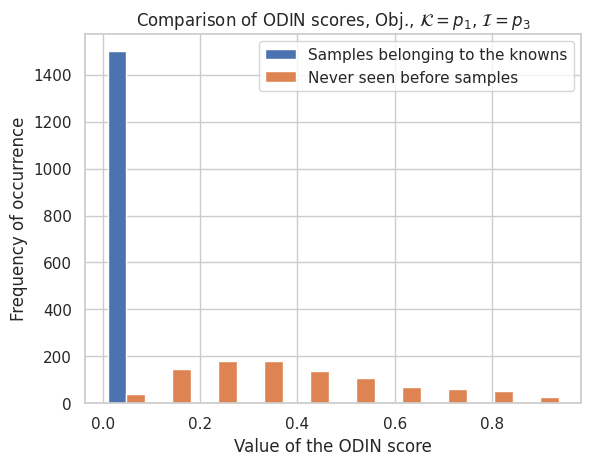

In [ ]:
plt.hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels

plt.xlabel('Value of the ODIN score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of ODIN scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

# Example of 1 model

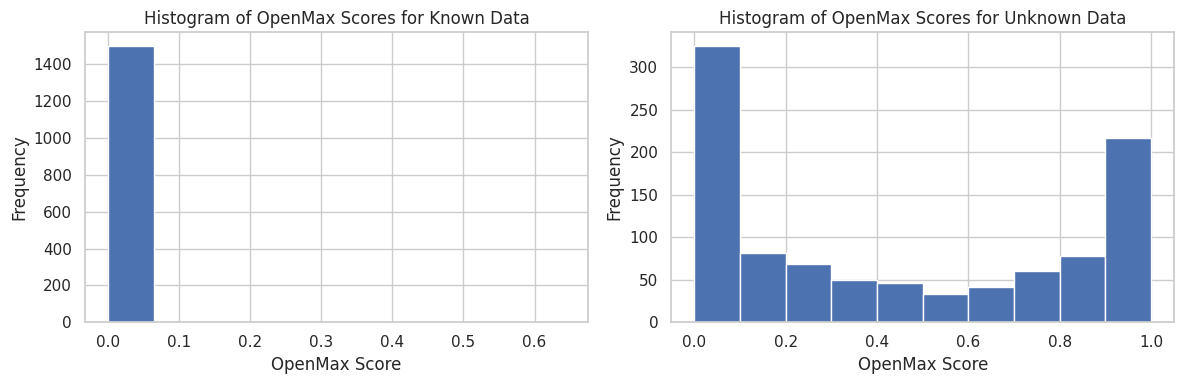

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

logits_layer = res_net01.layers[-2].output

logits_model = tf.keras.Model(inputs=res_net01.input, outputs=logits_layer)

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

known_logits = logits_model(Known_data_X_test_as_tensor)
unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

max_known_logits = tf.reduce_max(known_logits, axis=1)
max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

def compute_openmax_scores_known(max_known_logits, alpha=1.0):
    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))
    return scores_known

openmax_scores_known = compute_openmax_scores_known(max_known_logits)

def compute_openmax_scores_unknown(max_known_logits, max_unknown_logits, alpha=1.0):
    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)
    return tf.stack(scores_unknown)

openmax_scores_unknown = compute_openmax_scores_unknown(max_known_logits, max_unknown_logits)

openmax_scores_known = openmax_scores_known.numpy()
openmax_scores_unknown = openmax_scores_unknown.numpy()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(openmax_scores_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(openmax_scores_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()

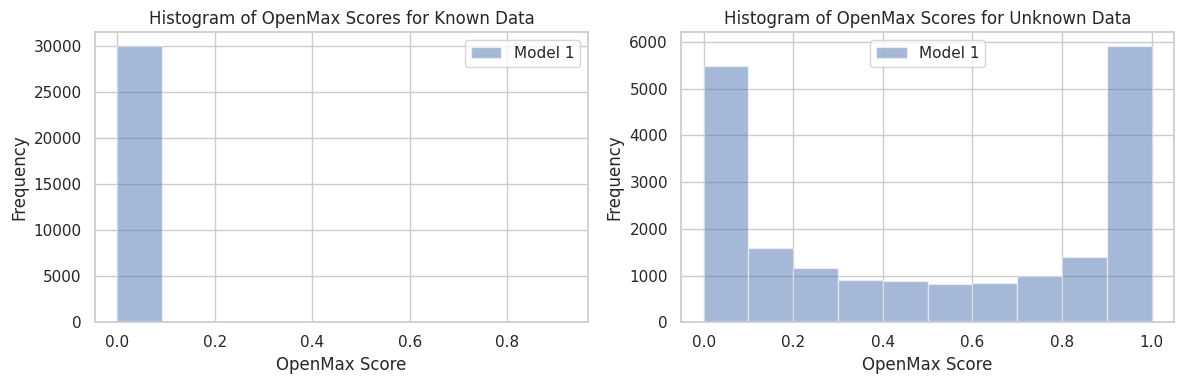

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

alpha = 1.0
num_models = 20

loaded_models = [res_net01, res_net02, res_net03, res_net04, res_net05, res_net06, res_net07, res_net08, res_net09, res_net10,
                 res_net11, res_net12, res_net13, res_net14, res_net15, res_net16, res_net17, res_net18, res_net19, res_net20]

openmax_scores_known = []
openmax_scores_unknown = []

Known_data_X_test_as_tensor = tf.convert_to_tensor(Known_data_X_test)
NeverSeen_data_X_test_as_tensor = tf.convert_to_tensor(NeverSeen_data_X_test)

for model in loaded_models:
    logits_layer = model.layers[-2].output

    logits_model = tf.keras.Model(inputs=model.input, outputs=logits_layer)

    known_logits = logits_model(Known_data_X_test_as_tensor)
    unknown_logits = logits_model(NeverSeen_data_X_test_as_tensor)

    max_known_logits = tf.reduce_max(known_logits, axis=1)
    max_unknown_logits = tf.reduce_max(unknown_logits, axis=1)

    scores_known = tf.exp(alpha * max_known_logits) / tf.reduce_sum(tf.exp(alpha * max_known_logits))

    scores_unknown = []
    for max_known, max_unknown in zip(max_known_logits, max_unknown_logits):
        unknown_score = tf.exp(alpha * max_known) / (tf.exp(alpha * max_known) + tf.exp(alpha * max_unknown))
        scores_unknown.append(unknown_score)

    openmax_scores_known.append(scores_known.numpy())
    openmax_scores_unknown.append(scores_unknown)

merged_openmax_scores_known = np.stack(openmax_scores_known, axis=1)
merged_openmax_scores_unknown = np.stack(openmax_scores_unknown, axis=1)

combined_openmax_scores_known = merged_openmax_scores_known.flatten()
combined_openmax_scores_unknown = merged_openmax_scores_unknown.flatten()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(combined_openmax_scores_known, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(combined_openmax_scores_unknown, bins=10, alpha=0.5, label=[f'Model {i+1}' for i in range(num_models)])
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt('/content/gdrive/MyDrive/Stanford_data/NaiveKp1p3_combined_openmax_scores_known.txt', combined_openmax_scores_known)
np.savetxt('/content/gdrive/MyDrive/Stanford_data/NaiveKp1p3_combined_openmax_scores_unknown.txt', combined_openmax_scores_unknown)


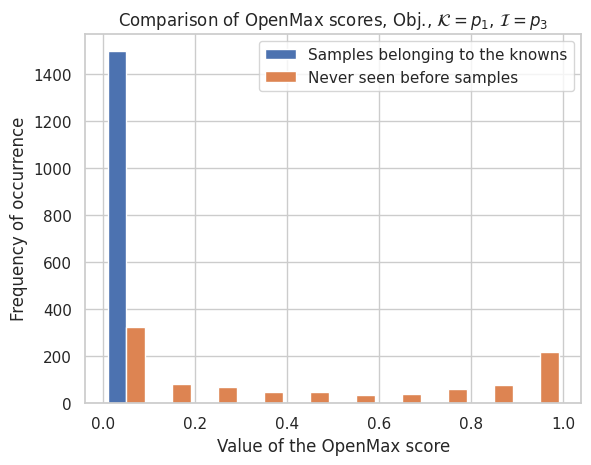

In [ ]:
plt.hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])

plt.xlabel('Value of the OpenMax score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of OpenMax scores, Naive, $\mathcal{K} = p_1 + p_3$, $\mathcal{I} = \emptyset$')

plt.legend()

plt.show()

In [ ]:
max(openmax_scores_known)

0.6427326

In [ ]:
min(openmax_scores_unknown)

1.8391194e-05

In [ ]:
import numpy as np

openmax_scores_known_sorted = np.sort(openmax_scores_known)
openmax_scores_unknown_sorted = np.sort(openmax_scores_unknown)

min_known_score = openmax_scores_known_sorted.min()
max_known_score = openmax_scores_known_sorted.max()
min_unknown_score = openmax_scores_unknown_sorted.min()
max_unknown_score = openmax_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(openmax_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(openmax_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")

Overlap (IoU): 1.71%


In [ ]:
import numpy as np
from scipy.spatial import distance
import tensorflow as tf

def preprocess_data(data):
    preprocessed_data = data
    return preprocessed_data

def extract_deep_features(model, data):
    preprocessed_data = preprocess_data(data)

    deep_features = model.layers[-2].output
    deep_feature_model = tf.keras.Model(inputs=model.input, outputs=deep_features)
    extracted_features = deep_feature_model.predict(preprocessed_data)

    return extracted_features

deep_features_known = extract_deep_features(res_net01, Known_data_X_test)
deep_features_unknown = extract_deep_features(res_net01, NeverSeen_data_X_test)

mean_known = np.mean(deep_features_known, axis=0)
cov_known = np.cov(deep_features_known, rowvar=False)

cond_number = np.linalg.cond(cov_known)
print("Condition Number of Covariance Matrix (Known Data):", cond_number)

epsilon = 1e-6

if cond_number > 1 / epsilon:
    cov_known_reg = cov_known + epsilon * np.eye(cov_known.shape[0])
else:
    cov_known_reg = cov_known

mahalanobis_distances_known = []
for feature in deep_features_known:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_known.append(mahalanobis_distance)

mahalanobis_distances_unknown = []
for feature in deep_features_unknown:
    mahalanobis_distance = distance.mahalanobis(feature, mean_known, np.linalg.inv(cov_known_reg))
    mahalanobis_distances_unknown.append(mahalanobis_distance)

threshold_known = 3.0
threshold_unknown = 4.0

ood_samples_known = [i for i, distance in enumerate(mahalanobis_distances_known) if distance > threshold_known]
ood_samples_unknown = [i for i, distance in enumerate(mahalanobis_distances_unknown) if distance > threshold_unknown]

print("Out-of-Distribution Sample Indices (Known Data):", ood_samples_known)
print("Out-of-Distribution Sample Indices (Unknown Data):", ood_samples_unknown)

32/32 [==============================] - 21s 590ms/step
Condition Number of Covariance Matrix (Known Data): 4.439165158466121e+21


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(mahalanobis_distances_known, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Known Data')

plt.subplot(1, 2, 2)
plt.hist(mahalanobis_distances_unknown, bins=10)
plt.xlabel('OpenMax Score')
plt.ylabel('Frequency')
plt.title('Histogram of OpenMax Scores for Unknown Data')

plt.tight_layout()
plt.show()

In [ ]:
plt.hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])  # Specify the number of bins and labels
plt.xlim(2.5, 15)

plt.xlabel('Value of the Mahalanobis score')
plt.ylabel('Frequency of occurrence')
plt.title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')

plt.legend()

plt.show()

In [ ]:
import numpy as np

mahalanobis_scores_known_sorted = np.sort(mahalanobis_distances_known)
mahalanobis_scores_unknown_sorted = np.sort(mahalanobis_distances_unknown)

min_known_score = mahalanobis_scores_known_sorted.min()
max_known_score = mahalanobis_scores_known_sorted.max()
min_unknown_score = mahalanobis_scores_unknown_sorted.min()
max_unknown_score = mahalanobis_scores_unknown_sorted.max()

bins = np.linspace(min(min_known_score, min_unknown_score), max(max_known_score, max_unknown_score), 1000)

hist_known, _ = np.histogram(mahalanobis_scores_known_sorted, bins)
hist_unknown, _ = np.histogram(mahalanobis_scores_unknown_sorted, bins)

intersection = np.minimum(hist_known, hist_unknown)
union = np.maximum(hist_known, hist_unknown)

iou = np.sum(intersection) / np.sum(union) * 100

print(f"Overlap (IoU): {iou:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()

plt.tight_layout()

plt.show()


In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].hist([odin_scores_KNOWN, odin_scores_UN_KNOWN], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[0].set_xlabel('Value of the ODIN score')
axs[0].set_ylabel('Frequency of occurrence')
axs[0].set_title('Comparison of ODIN scores, Obj.class, $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[0].legend()

axs[1].hist([openmax_scores_known, openmax_scores_unknown], bins=10, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[1].set_xlabel('Value of the OpenMax score')
axs[1].set_ylabel('Frequency of occurrence')
axs[1].set_title('Comparison of OpenMax scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[1].legend()

axs[2].hist([mahalanobis_distances_known, mahalanobis_distances_unknown], bins=25, label=['Samples belonging to the knowns', 'Never seen before samples'])
axs[2].set_xlabel('Value of the Mahalanobis score')
axs[2].set_ylabel('Frequency of occurrence')
axs[2].set_title('Comparison of Mahalanobis scores, Obj., $\mathcal{K} = p_1$, $\mathcal{I} = p_3$')
axs[2].legend()

plt.tight_layout()

plt.show()


# Separating $\mathcal{K}$ and $\mathcal{N}$ by a fixed (class-independendent) threshold

In [ ]:
prediction_known = prediction_known_ensemble_1
prediction_unknown = prediction_unknown_ensemble_1

In [ ]:
def thresholding(threshold):
  true = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] == Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      true += 1
  return true/(prediction_known.shape[0])

In [ ]:
CorrectThresholding = []
for i in range(90):
  CorrectThresholding.append([0.1 + 0.01*i,100*thresholding(0.1 + 0.01*i)])
for i in range(10):
  CorrectThresholding.append([0.99 + 0.001*i,100*thresholding(0.99 + 0.001*i)])
CorrectThresholding

[[0.1, 88.33333333333333],
 [0.11, 88.33333333333333],
 [0.12000000000000001, 88.33333333333333],
 [0.13, 88.33333333333333],
 [0.14, 88.33333333333333],
 [0.15000000000000002, 88.33333333333333],
 [0.16, 88.33333333333333],
 [0.17, 88.33333333333333],
 [0.18, 88.33333333333333],
 [0.19, 88.33333333333333],
 [0.2, 88.33333333333333],
 [0.21000000000000002, 88.33333333333333],
 [0.22, 88.33333333333333],
 [0.23, 88.33333333333333],
 [0.24000000000000002, 88.33333333333333],
 [0.25, 88.33333333333333],
 [0.26, 88.33333333333333],
 [0.27, 88.33333333333333],
 [0.28, 88.33333333333333],
 [0.29000000000000004, 88.33333333333333],
 [0.30000000000000004, 88.33333333333333],
 [0.31, 88.33333333333333],
 [0.32, 88.33333333333333],
 [0.33, 88.33333333333333],
 [0.33999999999999997, 88.33333333333333],
 [0.35, 88.26666666666667],
 [0.36, 88.26666666666667],
 [0.37, 88.26666666666667],
 [0.38, 88.26666666666667],
 [0.39, 88.2],
 [0.4, 88.13333333333333],
 [0.41000000000000003, 88.06666666666668],


In [ ]:
def false_identify(threshold):
  false_identify = 0
  for i in range(prediction_known.shape[0]):
    if prediction_known.argmax(axis=1)[i] != Known_data_X_test_label_int[i] and max(prediction_known[i]) > threshold:
      false_identify += 1
  return false_identify/(prediction_known.shape[0])

In [ ]:
FalseIdentify = []
for i in range(90):
  FalseIdentify.append([0.1 + 0.01*i,100*false_identify(0.1 + 0.01*i)])
for i in range(10):
  FalseIdentify.append([0.99 + 0.001*i,100*false_identify(0.99 + 0.001*i)])
FalseIdentify

[[0.1, 11.666666666666666],
 [0.11, 11.666666666666666],
 [0.12000000000000001, 11.666666666666666],
 [0.13, 11.666666666666666],
 [0.14, 11.666666666666666],
 [0.15000000000000002, 11.666666666666666],
 [0.16, 11.666666666666666],
 [0.17, 11.666666666666666],
 [0.18, 11.666666666666666],
 [0.19, 11.666666666666666],
 [0.2, 11.666666666666666],
 [0.21000000000000002, 11.666666666666666],
 [0.22, 11.666666666666666],
 [0.23, 11.666666666666666],
 [0.24000000000000002, 11.666666666666666],
 [0.25, 11.666666666666666],
 [0.26, 11.666666666666666],
 [0.27, 11.600000000000001],
 [0.28, 11.600000000000001],
 [0.29000000000000004, 11.600000000000001],
 [0.30000000000000004, 11.600000000000001],
 [0.31, 11.533333333333333],
 [0.32, 11.533333333333333],
 [0.33, 11.466666666666667],
 [0.33999999999999997, 11.333333333333332],
 [0.35, 11.333333333333332],
 [0.36, 11.266666666666666],
 [0.37, 11.200000000000001],
 [0.38, 11.200000000000001],
 [0.39, 11.200000000000001],
 [0.4, 11.200000000000001],

In [ ]:
def misclassifyunknown(threshold):
  misclassifyunknown = 0
  for i in range(prediction_unknown.shape[0]):
    if max(prediction_unknown[i]) > threshold:
      misclassifyunknown += 1
  return misclassifyunknown/(prediction_unknown.shape[0])

In [ ]:
UnknownMisclassify = []
for i in range(90):
  UnknownMisclassify.append([0.1 + 0.01*i,100*misclassifyunknown(0.1 + 0.01*i)])
for i in range(10):
  UnknownMisclassify.append([0.99 + 0.001*i,100*misclassifyunknown(0.99 + 0.001*i)])
UnknownMisclassify

[[0.1, 100.0],
 [0.11, 100.0],
 [0.12000000000000001, 100.0],
 [0.13, 100.0],
 [0.14, 100.0],
 [0.15000000000000002, 100.0],
 [0.16, 100.0],
 [0.17, 100.0],
 [0.18, 100.0],
 [0.19, 100.0],
 [0.2, 100.0],
 [0.21000000000000002, 100.0],
 [0.22, 100.0],
 [0.23, 100.0],
 [0.24000000000000002, 100.0],
 [0.25, 100.0],
 [0.26, 100.0],
 [0.27, 100.0],
 [0.28, 100.0],
 [0.29000000000000004, 100.0],
 [0.30000000000000004, 100.0],
 [0.31, 99.9],
 [0.32, 99.6],
 [0.33, 99.6],
 [0.33999999999999997, 99.6],
 [0.35, 99.6],
 [0.36, 99.3],
 [0.37, 99.2],
 [0.38, 99.1],
 [0.39, 99.0],
 [0.4, 98.8],
 [0.41000000000000003, 98.6],
 [0.42000000000000004, 98.6],
 [0.43000000000000005, 98.3],
 [0.44000000000000006, 98.2],
 [0.45000000000000007, 98.0],
 [0.45999999999999996, 97.8],
 [0.47, 97.6],
 [0.48, 97.39999999999999],
 [0.49, 96.89999999999999],
 [0.5, 95.89999999999999],
 [0.51, 95.19999999999999],
 [0.52, 94.19999999999999],
 [0.53, 93.4],
 [0.54, 92.30000000000001],
 [0.55, 91.5],
 [0.56, 90.5],
 [0.5

In [ ]:
def dontknow(threshold):
  notknown = 0
  for i in range(prediction_known.shape[0]):
    if max(prediction_known[i]) <= threshold:
      notknown += 1
  return notknown/(prediction_known.shape[0])

In [ ]:
DontKnowThresholding = []
for i in range(90):
  DontKnowThresholding.append([0.1 + 0.01*i,100*dontknow(0.1 + 0.01*i)])
for i in range(10):
  DontKnowThresholding.append([0.99 + 0.001*i,100*dontknow(0.99 + 0.001*i)])
DontKnowThresholding

[[0.1, 0.0],
 [0.11, 0.0],
 [0.12000000000000001, 0.0],
 [0.13, 0.0],
 [0.14, 0.0],
 [0.15000000000000002, 0.0],
 [0.16, 0.0],
 [0.17, 0.0],
 [0.18, 0.0],
 [0.19, 0.0],
 [0.2, 0.0],
 [0.21000000000000002, 0.0],
 [0.22, 0.0],
 [0.23, 0.0],
 [0.24000000000000002, 0.0],
 [0.25, 0.0],
 [0.26, 0.0],
 [0.27, 0.06666666666666667],
 [0.28, 0.06666666666666667],
 [0.29000000000000004, 0.06666666666666667],
 [0.30000000000000004, 0.06666666666666667],
 [0.31, 0.13333333333333333],
 [0.32, 0.13333333333333333],
 [0.33, 0.2],
 [0.33999999999999997, 0.33333333333333337],
 [0.35, 0.4],
 [0.36, 0.46666666666666673],
 [0.37, 0.5333333333333333],
 [0.38, 0.5333333333333333],
 [0.39, 0.6],
 [0.4, 0.6666666666666667],
 [0.41000000000000003, 0.7333333333333333],
 [0.42000000000000004, 0.8],
 [0.43000000000000005, 0.8],
 [0.44000000000000006, 1.2],
 [0.45000000000000007, 1.2],
 [0.45999999999999996, 1.4000000000000001],
 [0.47, 1.5333333333333332],
 [0.48, 1.7333333333333332],
 [0.49, 1.7999999999999998],


In [ ]:
aligned_array = [element for row in prediction_unknown for element in row]
# Find the maximum value in the aligned array
max_value = max(aligned_array)

# The max_value variable now contains the maximum value in the aligned array
print("The maximum value in the aligned array is:", max_value)


The maximum value in the aligned array is: 0.9999999


In [ ]:
thresholding(max_value)

0.0006666666666666666

In [ ]:
dontknow(max_value)

0.9993333333333333

In [ ]:
misclassifyunknown(max_value)

0.0

In [ ]:
false_identify(max_value)

0.0

In [ ]:
DontKnowThresholdingANOTHER = []

for i in range(89):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.1 + 0.01*i),100*dontknow(0.1 + 0.01*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99 + 0.001*i),100*dontknow(0.99 + 0.001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*dontknow(0.999 + 0.0001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*dontknow(0.9999 + 0.00001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*dontknow(0.99999 + 0.000001*i),])

for i in range(10):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*dontknow(0.999999 + 0.0000001*i),])

for i in range(9):
  DontKnowThresholdingANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*dontknow(0.9999999 + 0.00000001*i),])

DontKnowThresholdingANOTHER.append([100*thresholding(max_value),100*dontknow(max_value)])

DontKnowThresholdingANOTHER

[[88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.0],
 [88.33333333333333, 0.06666666666666667],
 [88.33333333333333, 0.06666666666666667],
 [88.33333333333333, 0.06666666666666667],
 [88.33333333333333, 0.06666666666666667],
 [88.33333333333333, 0.13333333333333333],
 [88.33333333333333, 0.13333333333333333],
 [88.33333333333333, 0.2],
 [88.33333333333333, 0.33333333333333337],
 [88.26666666666667, 0.4],
 [88.26666666666667, 0.46666666666666673],
 [88.26666666666667, 0.5333333333333333],
 [88.26666666666667, 0.5333333333333333],
 [88.2, 0.6],
 [88.13333333333333, 0.6666666666666667],
 [8

In [ ]:
UnknownMisclassifyANOTHER = []
for i in range(89):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*misclassifyunknown(0.1 + 0.01*i),])
for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*misclassifyunknown(0.99 + 0.001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*misclassifyunknown(0.999 + 0.0001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*misclassifyunknown(0.9999 + 0.00001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*misclassifyunknown(0.99999 + 0.000001*i),])

for i in range(10):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*misclassifyunknown(0.999999 + 0.0000001*i),])

for i in range(9):
  UnknownMisclassifyANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*misclassifyunknown(0.9999999 + 0.00000001*i),])

UnknownMisclassifyANOTHER.append([100*thresholding(max_value),100*misclassifyunknown(max_value),])

UnknownMisclassifyANOTHER

[[88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 100.0],
 [88.33333333333333, 99.9],
 [88.33333333333333, 99.6],
 [88.33333333333333, 99.6],
 [88.33333333333333, 99.6],
 [88.26666666666667, 99.6],
 [88.26666666666667, 99.3],
 [88.26666666666667, 99.2],
 [88.26666666666667, 99.1],
 [88.2, 99.0],
 [88.13333333333333, 98.8],
 [88.06666666666668, 98.6],
 [88.06666666666668, 98.6],
 [88.06666666666668, 98.3],
 [87.86666666666667, 98.2],
 [87.8666666

In [ ]:
FalseIdentifyANOTHER = []
for i in range(89):
  FalseIdentifyANOTHER.append([100*thresholding(0.1 + 0.01*i),100*false_identify(0.1 + 0.01*i),])
for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.99 + 0.001*i),100*false_identify(0.99 + 0.001*i)])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.999 + 0.0001*i),100*false_identify(0.999 + 0.0001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.9999 + 0.00001*i),100*false_identify(0.9999 + 0.00001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.99999 + 0.000001*i),100*false_identify(0.99999 + 0.000001*i),])

for i in range(10):
  FalseIdentifyANOTHER.append([100*thresholding(0.999999 + 0.0000001*i),100*false_identify(0.999999 + 0.0000001*i),])

for i in range(9):
  FalseIdentifyANOTHER.append([100*thresholding(0.9999999 + 0.00000001*i),100*false_identify(0.9999999 + 0.00000001*i),])

FalseIdentifyANOTHER.append([100*thresholding(max_value),100*false_identify(max_value),])
FalseIdentifyANOTHER

[[88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.666666666666666],
 [88.33333333333333, 11.600000000000001],
 [88.33333333333333, 11.600000000000001],
 [88.33333333333333, 11.600000000000001],
 [88.33333333333333, 11.600000000000001],
 [88.33333333333333, 11.533333333333333],
 [88.33333333333333, 11.533333333333333],
 [88.33333333333333, 11.4666666666

# Class-adaptive threshold

# Run #1

In [ ]:
prediction_known = prediction_known_ensemble_1
prediction_unknown = prediction_unknown_ensemble_1

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(15):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

0

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

2

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

184
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[184])] = max(prediction_known[184])

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

15

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

46

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

344
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[344])] = max(prediction_known[344])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

5

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

416
418
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[416])] = max(prediction_known[416])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

87

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

72

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

602
603
604
607
608
616
618
619
623
624
628
630
651
699
Number of mistakes in this class: 14


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[699])] = max(prediction_known[699])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

69

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

Number of mistakes in this class: 0


In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

99

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

7

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

923
944
982
985
Number of mistakes in this class: 4


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[985])] = max(prediction_known[985])

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count10 = 0
for i in range(100):
  if prediction_known[i + 10*100,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[i + 10*100]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0
C_count10

7

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

Number of mistakes in this class: 0


In [ ]:
C_count11 = 0
for i in range(100):
  if prediction_known[i + 11*100,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[i + 11*100]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0
C_count11

32

In [ ]:
mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0
print("Number of mistakes in this class:",mistake11)

Number of mistakes in this class: 0


In [ ]:
C_count12 = 0
for i in range(100):
  if prediction_known[i + 12*100,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[i + 12*100]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0
C_count12

22

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

Number of mistakes in this class: 0


In [ ]:
C_count13 = 0
for i in range(100):
  if prediction_known[i + 13*100,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[i + 13*100]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0
C_count13

89

In [ ]:
mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0
print("Number of mistakes in this class:",mistake13)

Number of mistakes in this class: 0


In [ ]:
C_count14 = 0
for i in range(100):
  if prediction_known[i + 14*100,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[i + 14*100]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0
C_count14

60

In [ ]:
mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0
print("Number of mistakes in this class:",mistake14)

Number of mistakes in this class: 0


In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0

mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0

mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0


mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0


mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7,mistake8,mistake9,mistake10,mistake11,mistake12,mistake13,mistake14]
NumberOfMistakesAfterThrAdj

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0

C_count10 = 0
for i in range(100):
  if prediction_known[1000 + i,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[1000 + i]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0

C_count11 = 0
for i in range(100):
  if prediction_known[1100 + i,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[1100 + i]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0


C_count12 = 0
for i in range(100):
  if prediction_known[1200 + i,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[1200 + i]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0


C_count13 = 0
for i in range(100):
  if prediction_known[1300 + i,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[1300 + i]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0


C_count14 = 0
for i in range(100):
  if prediction_known[1400 + i,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[1400 + i]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0

In [ ]:
FinalDistributionOver10ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun1

[[1, 0],
 [2, 2],
 [3, 15],
 [4, 46],
 [5, 5],
 [6, 45],
 [7, 72],
 [8, 28],
 [9, 99],
 [10, 7]]

In [ ]:
FinalDistributionOver15ClassesRun1 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14]]
FinalDistributionOver15ClassesRun1

[[1, 0],
 [2, 2],
 [3, 15],
 [4, 46],
 [5, 5],
 [6, 45],
 [7, 72],
 [8, 28],
 [9, 99],
 [10, 7],
 [11, 7],
 [12, 32],
 [13, 22],
 [14, 89],
 [15, 60]]

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.319

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14)/1500

0.3526666666666667

# Run #2

In [ ]:
prediction_known = prediction_known_ensemble_2
prediction_unknown = prediction_unknown_ensemble_2

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(15):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

0

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

2

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

184
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[184])] = max(prediction_known[184])

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

11

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

42

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

306
344
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[344])] = max(prediction_known[344])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

4

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

416
418
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[418])] = max(prediction_known[418])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

94

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

65

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

602
603
604
607
608
616
618
619
623
624
628
630
651
657
661
665
681
697
699
Number of mistakes in this class: 19


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[699])] = max(prediction_known[699])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

71

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

Number of mistakes in this class: 0


In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

99

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

1

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

918
923
944
982
985
Number of mistakes in this class: 5


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[985])] = max(prediction_known[985])

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count10 = 0
for i in range(100):
  if prediction_known[i + 10*100,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[i + 10*100]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0
C_count10

6

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

Number of mistakes in this class: 0


In [ ]:
C_count11 = 0
for i in range(100):
  if prediction_known[i + 11*100,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[i + 11*100]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0
C_count11

31

In [ ]:
mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0
print("Number of mistakes in this class:",mistake11)

Number of mistakes in this class: 0


In [ ]:
C_count12 = 0
for i in range(100):
  if prediction_known[i + 12*100,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[i + 12*100]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0
C_count12

10

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

Number of mistakes in this class: 0


In [ ]:
C_count13 = 0
for i in range(100):
  if prediction_known[i + 13*100,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[i + 13*100]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0
C_count13

90

In [ ]:
mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0
print("Number of mistakes in this class:",mistake13)

Number of mistakes in this class: 0


In [ ]:
C_count14 = 0
for i in range(100):
  if prediction_known[i + 14*100,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[i + 14*100]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0
C_count14

73

In [ ]:
mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0
print("Number of mistakes in this class:",mistake14)

Number of mistakes in this class: 0


In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0

mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0

mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0


mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0


mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7,mistake8,mistake9,mistake10,mistake11,mistake12,mistake13,mistake14]
NumberOfMistakesAfterThrAdj

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0

C_count10 = 0
for i in range(100):
  if prediction_known[1000 + i,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[1000 + i]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0

C_count11 = 0
for i in range(100):
  if prediction_known[1100 + i,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[1100 + i]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0


C_count12 = 0
for i in range(100):
  if prediction_known[1200 + i,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[1200 + i]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0


C_count13 = 0
for i in range(100):
  if prediction_known[1300 + i,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[1300 + i]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0


C_count14 = 0
for i in range(100):
  if prediction_known[1400 + i,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[1400 + i]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0

In [ ]:
FinalDistributionOver10ClassesRun2 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun2

[[1, 0],
 [2, 2],
 [3, 11],
 [4, 42],
 [5, 4],
 [6, 41],
 [7, 65],
 [8, 28],
 [9, 99],
 [10, 1]]

In [ ]:
FinalDistributionOver15ClassesRun2 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14]]
FinalDistributionOver15ClassesRun2

[[1, 0],
 [2, 2],
 [3, 11],
 [4, 42],
 [5, 4],
 [6, 41],
 [7, 65],
 [8, 28],
 [9, 99],
 [10, 1],
 [11, 6],
 [12, 31],
 [13, 10],
 [14, 90],
 [15, 73]]

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.293

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14)/1500

0.3353333333333333

# Run #3

In [ ]:
prediction_known = prediction_known_ensemble_3
prediction_unknown = prediction_unknown_ensemble_3

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(15):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

0

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

2

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

184
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[184])] = max(prediction_known[184])

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

10

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

43

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

344
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[344])] = max(prediction_known[344])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

5

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

416
418
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[418])] = max(prediction_known[418])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

88

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

66

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

602
603
604
607
608
616
618
619
623
624
628
630
651
657
699
Number of mistakes in this class: 15


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[699])] = max(prediction_known[699])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

67

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

Number of mistakes in this class: 0


In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

99

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

4

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

923
944
982
985
Number of mistakes in this class: 4


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[985])] = max(prediction_known[985])

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count10 = 0
for i in range(100):
  if prediction_known[i + 10*100,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[i + 10*100]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0
C_count10

9

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

Number of mistakes in this class: 0


In [ ]:
C_count11 = 0
for i in range(100):
  if prediction_known[i + 11*100,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[i + 11*100]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0
C_count11

39

In [ ]:
mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0
print("Number of mistakes in this class:",mistake11)

Number of mistakes in this class: 0


In [ ]:
C_count12 = 0
for i in range(100):
  if prediction_known[i + 12*100,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[i + 12*100]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0
C_count12

6

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

Number of mistakes in this class: 0


In [ ]:
C_count13 = 0
for i in range(100):
  if prediction_known[i + 13*100,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[i + 13*100]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0
C_count13

93

In [ ]:
mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0
print("Number of mistakes in this class:",mistake13)

Number of mistakes in this class: 0


In [ ]:
C_count14 = 0
for i in range(100):
  if prediction_known[i + 14*100,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[i + 14*100]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0
C_count14

67

In [ ]:
mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0
print("Number of mistakes in this class:",mistake14)

Number of mistakes in this class: 0


In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0

mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0

mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0


mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0


mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7,mistake8,mistake9,mistake10,mistake11,mistake12,mistake13,mistake14]
NumberOfMistakesAfterThrAdj

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0

C_count10 = 0
for i in range(100):
  if prediction_known[1000 + i,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[1000 + i]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0

C_count11 = 0
for i in range(100):
  if prediction_known[1100 + i,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[1100 + i]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0


C_count12 = 0
for i in range(100):
  if prediction_known[1200 + i,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[1200 + i]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0


C_count13 = 0
for i in range(100):
  if prediction_known[1300 + i,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[1300 + i]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0


C_count14 = 0
for i in range(100):
  if prediction_known[1400 + i,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[1400 + i]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0

In [ ]:
FinalDistributionOver10ClassesRun3 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun3

[[1, 0],
 [2, 2],
 [3, 10],
 [4, 43],
 [5, 5],
 [6, 50],
 [7, 66],
 [8, 25],
 [9, 99],
 [10, 4]]

In [ ]:
FinalDistributionOver15ClassesRun3 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14]]
FinalDistributionOver15ClassesRun3

[[1, 0],
 [2, 2],
 [3, 10],
 [4, 43],
 [5, 5],
 [6, 50],
 [7, 66],
 [8, 25],
 [9, 99],
 [10, 4],
 [11, 9],
 [12, 39],
 [13, 6],
 [14, 93],
 [15, 67]]

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.304

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14)/1500

0.3453333333333333

# Run #4

In [ ]:
prediction_known = prediction_known_ensemble_4
prediction_unknown = prediction_unknown_ensemble_4

In [ ]:
ThresholdNeverSeenBefores = []
for i in range(15):
  ThresholdNeverSeenBefores.append(np.max(prediction_unknown[:,i]))

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0
C_count0

0

In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0
mistake0
print("Number of mistakes in this class:",mistake0)

Number of mistakes in this class: 0


In [ ]:
C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0
C_count1

1

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

184
Number of mistakes in this class: 1


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[184])] = max(prediction_known[184])

In [ ]:
mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0
mistake1
print("Number of mistakes in this class:",mistake1)

Number of mistakes in this class: 0


In [ ]:
C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0
C_count2

15

In [ ]:
mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0
mistake2
print("Number of mistakes in this class:",mistake2)

Number of mistakes in this class: 0


In [ ]:
C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0
C_count3

48

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

306
344
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[344])] = max(prediction_known[344])

In [ ]:
mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0
mistake3
print("Number of mistakes in this class:",mistake3)

Number of mistakes in this class: 0


In [ ]:
C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0
C_count4

4

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

416
418
Number of mistakes in this class: 2


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[418])] = max(prediction_known[418])

In [ ]:
mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0
print("Number of mistakes in this class:",mistake4)

Number of mistakes in this class: 0


In [ ]:
C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0
C_count5

92

In [ ]:
mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0
print("Number of mistakes in this class:",mistake5)

Number of mistakes in this class: 0


In [ ]:
C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0
C_count6

72

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

602
603
604
607
608
616
618
619
623
624
628
630
651
657
699
Number of mistakes in this class: 15


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[651])] = max(prediction_known[651])

In [ ]:
mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0
print("Number of mistakes in this class:",mistake6)

Number of mistakes in this class: 0


In [ ]:
C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0
C_count7

66

In [ ]:
mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0
print("Number of mistakes in this class:",mistake7)

Number of mistakes in this class: 0


In [ ]:
C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0
C_count8

99

In [ ]:
mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0
print("Number of mistakes in this class:",mistake8)

Number of mistakes in this class: 0


In [ ]:
C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0
C_count9

2

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

918
923
944
985
Number of mistakes in this class: 4


In [ ]:
ThresholdNeverSeenBefores[np.argmax(prediction_known[985])] = max(prediction_known[985])

In [ ]:
mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0
print("Number of mistakes in this class:",mistake9)

Number of mistakes in this class: 0


In [ ]:
C_count10 = 0
for i in range(100):
  if prediction_known[i + 10*100,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[i + 10*100]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0
C_count10

7

In [ ]:
mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0
print("Number of mistakes in this class:",mistake10)

Number of mistakes in this class: 0


In [ ]:
C_count11 = 0
for i in range(100):
  if prediction_known[i + 11*100,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[i + 11*100]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0
C_count11

48

In [ ]:
mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0
print("Number of mistakes in this class:",mistake11)

Number of mistakes in this class: 0


In [ ]:
C_count12 = 0
for i in range(100):
  if prediction_known[i + 12*100,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[i + 12*100]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0
C_count12

11

In [ ]:
mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0
print("Number of mistakes in this class:",mistake12)

Number of mistakes in this class: 0


In [ ]:
C_count13 = 0
for i in range(100):
  if prediction_known[i + 13*100,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[i + 13*100]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0
C_count13

92

In [ ]:
mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0
print("Number of mistakes in this class:",mistake13)

Number of mistakes in this class: 0


In [ ]:
C_count14 = 0
for i in range(100):
  if prediction_known[i + 14*100,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[i + 14*100]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0
C_count14

56

In [ ]:
mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0
print("Number of mistakes in this class:",mistake14)

Number of mistakes in this class: 0


In [ ]:
mistake0 = 0
for i in range(100):
  if np.argmax(prediction_known[i]) != 0 and max(prediction_known[i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[i])]:
    mistake0 += 1
    print(i)
  else:
    mistake0 += 0

mistake1 = 0
for i in range(100):
  if np.argmax(prediction_known[100 + i]) != 1 and max(prediction_known[100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[100 + i])]:
    mistake1 += 1
    print(100 + i)
  else:
    mistake1 += 0

mistake2 = 0
for i in range(100):
  if np.argmax(prediction_known[200 + i]) != 2 and max(prediction_known[200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[200 + i])]:
    mistake2 += 1
    print(200 + i)
  else:
    mistake2 += 0

mistake3 = 0
for i in range(100):
  if np.argmax(prediction_known[300 + i]) != 3 and max(prediction_known[300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[300 + i])]:
    mistake3 += 1
    print(300 + i)
  else:
    mistake3 += 0

mistake4 = 0
for i in range(100):
  if np.argmax(prediction_known[400 + i]) != 4 and max(prediction_known[400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[400 + i])]:
    mistake4 += 1
    print(400 + i)
  else:
    mistake4 += 0

mistake5 = 0
for i in range(100):
  if np.argmax(prediction_known[500 + i]) != 5 and max(prediction_known[500 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[500 + i])]:
    mistake5 += 1
    print(500 + i)
  else:
    mistake5 += 0

mistake6 = 0
for i in range(100):
  if np.argmax(prediction_known[600 + i]) != 6 and max(prediction_known[600 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[600 + i])]:
    mistake6 += 1
    print(600 + i)
  else:
    mistake6 += 0

mistake7 = 0
for i in range(100):
  if np.argmax(prediction_known[700 + i]) != 7 and max(prediction_known[700 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[700 + i])]:
    mistake7 += 1
    print(700 + i)
  else:
    mistake7 += 0

mistake8 = 0
for i in range(100):
  if np.argmax(prediction_known[800 + i]) != 8 and max(prediction_known[800 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[800 + i])]:
    mistake8 += 1
    print(800 + i)
  else:
    mistake8 += 0

mistake9 = 0
for i in range(100):
  if np.argmax(prediction_known[900 + i]) != 9 and max(prediction_known[900 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[900 + i])]:
    mistake9 += 1
    print(900 + i)
  else:
    mistake9 += 0

mistake10 = 0
for i in range(100):
  if np.argmax(prediction_known[1000 + i]) != 10 and max(prediction_known[1000 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1000 + i])]:
    mistake10 += 1
    print(1000 + i)
  else:
    mistake10 += 0

mistake11 = 0
for i in range(100):
  if np.argmax(prediction_known[1100 + i]) != 11 and max(prediction_known[1100 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1100 + i])]:
    mistake11 += 1
    print(1100 + i)
  else:
    mistake11 += 0

mistake12 = 0
for i in range(100):
  if np.argmax(prediction_known[1200 + i]) != 12 and max(prediction_known[1200 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1200 + i])]:
    mistake12 += 1
    print(1200 + i)
  else:
    mistake12 += 0


mistake13 = 0
for i in range(100):
  if np.argmax(prediction_known[1300 + i]) != 13 and max(prediction_known[1300 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1300 + i])]:
    mistake13 += 1
    print(1300 + i)
  else:
    mistake13 += 0


mistake14 = 0
for i in range(100):
  if np.argmax(prediction_known[1400 + i]) != 14 and max(prediction_known[1400 + i]) > ThresholdNeverSeenBefores[np.argmax(prediction_known[1400 + i])]:
    mistake14 += 1
    print(1400 + i)
  else:
    mistake14 += 0

NumberOfMistakesAfterThrAdj = [mistake0, mistake1, mistake2, mistake3, mistake4, mistake5, mistake6, mistake7,mistake8,mistake9,mistake10,mistake11,mistake12,mistake13,mistake14]
NumberOfMistakesAfterThrAdj

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
C_count0 = 0
for i in range(100):
  if prediction_known[i,0] > ThresholdNeverSeenBefores[0] and np.argmax(prediction_known[i]) == 0:
    C_count0 += 1
  else:
    C_count0 += 0

C_count1 = 0
for i in range(100):
  if prediction_known[100 + i,1] > ThresholdNeverSeenBefores[1] and np.argmax(prediction_known[100 + i]) == 1:
    C_count1 += 1
  else:
    C_count1 += 0

C_count2 = 0
for i in range(100):
  if prediction_known[200 + i,2] > ThresholdNeverSeenBefores[2] and np.argmax(prediction_known[200 + i]) == 2:
    C_count2 += 1
  else:
    C_count2 += 0

C_count3 = 0
for i in range(100):
  if prediction_known[300 + i,3] > ThresholdNeverSeenBefores[3] and np.argmax(prediction_known[300 + i]) == 3:
    C_count3 += 1
  else:
    C_count3 += 0

C_count4 = 0
for i in range(100):
  if prediction_known[400 + i,4] > ThresholdNeverSeenBefores[4] and np.argmax(prediction_known[400 + i]) == 4:
    C_count4 += 1
  else:
    C_count4 += 0

C_count5 = 0
for i in range(100):
  if prediction_known[500 + i,5] > ThresholdNeverSeenBefores[5] and np.argmax(prediction_known[500 + i]) == 5:
    C_count5 += 1
  else:
    C_count5 += 0

C_count6 = 0
for i in range(100):
  if prediction_known[600 + i,6] > ThresholdNeverSeenBefores[6] and np.argmax(prediction_known[600 + i]) == 6:
    C_count6 += 1
  else:
    C_count6 += 0

C_count7 = 0
for i in range(100):
  if prediction_known[700 + i,7] > ThresholdNeverSeenBefores[7]  and np.argmax(prediction_known[700 + i]) == 7:
    C_count7 += 1
  else:
    C_count7 += 0

C_count8 = 0
for i in range(100):
  if prediction_known[800 + i,8] > ThresholdNeverSeenBefores[8] and np.argmax(prediction_known[800 + i]) == 8:
    C_count8 += 1
  else:
    C_count8 += 0

C_count9 = 0
for i in range(100):
  if prediction_known[900 + i,9] > ThresholdNeverSeenBefores[9] and np.argmax(prediction_known[900 + i]) == 9:
    C_count9 += 1
  else:
    C_count9 += 0

C_count10 = 0
for i in range(100):
  if prediction_known[1000 + i,10] > ThresholdNeverSeenBefores[10] and np.argmax(prediction_known[1000 + i]) == 10:
    C_count10 += 1
  else:
    C_count10 += 0

C_count11 = 0
for i in range(100):
  if prediction_known[1100 + i,11] > ThresholdNeverSeenBefores[11] and np.argmax(prediction_known[1100 + i]) == 11:
    C_count11 += 1
  else:
    C_count11 += 0


C_count12 = 0
for i in range(100):
  if prediction_known[1200 + i,12] > ThresholdNeverSeenBefores[12] and np.argmax(prediction_known[1200 + i]) == 12:
    C_count12 += 1
  else:
    C_count12 += 0


C_count13 = 0
for i in range(100):
  if prediction_known[1300 + i,13] > ThresholdNeverSeenBefores[13] and np.argmax(prediction_known[1300 + i]) == 13:
    C_count13 += 1
  else:
    C_count13 += 0


C_count14 = 0
for i in range(100):
  if prediction_known[1400 + i,14] > ThresholdNeverSeenBefores[14] and np.argmax(prediction_known[1400 + i]) == 14:
    C_count14 += 1
  else:
    C_count14 += 0

In [ ]:
FinalDistributionOver10ClassesRun4 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9]]
FinalDistributionOver10ClassesRun4

[[1, 0],
 [2, 1],
 [3, 15],
 [4, 48],
 [5, 4],
 [6, 50],
 [7, 72],
 [8, 27],
 [9, 99],
 [10, 2]]

In [ ]:
FinalDistributionOver15ClassesRun4 = [[1,C_count0],[2,C_count1],[3,C_count2],[4,C_count3],[5,C_count4],[6,C_count5],[7,C_count6],[8,C_count7],[9,C_count8],[10,C_count9],[11,C_count10],[12,C_count11],[13,C_count12],[14,C_count13],[15,C_count14]]
FinalDistributionOver15ClassesRun4

[[1, 0],
 [2, 1],
 [3, 15],
 [4, 48],
 [5, 4],
 [6, 50],
 [7, 72],
 [8, 27],
 [9, 99],
 [10, 2],
 [11, 7],
 [12, 48],
 [13, 11],
 [14, 92],
 [15, 56]]

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9)/1000

0.318

In [ ]:
(C_count0 + C_count1 + C_count2 + C_count3 + C_count4 + C_count5 + C_count6 + C_count7 + C_count8 + C_count9 + C_count10 + C_count11 + C_count12 + C_count13 + C_count14)/1500

0.3546666666666667

In [ ]:
import numpy as np

# Combine the datasets into one list of lists
all_datasets = [FinalDistributionOver10ClassesRun1, FinalDistributionOver10ClassesRun2, FinalDistributionOver10ClassesRun3, FinalDistributionOver10ClassesRun4]

# Initialize an empty list to store the new dataset
new_dataset = []

# Loop through x values from 1 to 10
for x_value in range(1, 11):
    y_values = []

    # Extract y values for each dataset corresponding to the current x_value
    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    # Calculate the average y value and standard deviation
    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    # Append the new data point to the new dataset
    new_dataset.append([x_value, avg_y, std_y])

# Print the new dataset
for data_point in new_dataset:
    print(data_point)

[1, 0.0, 0.0]
[2, 1.75, 0.4330127018922193]
[3, 12.75, 2.277608394786075]
[4, 44.75, 2.384848003542364]
[5, 4.5, 0.5]
[6, 46.5, 3.774917217635375]
[7, 68.75, 3.2691742076555053]
[8, 27.0, 1.224744871391589]
[9, 99.0, 0.0]
[10, 3.5, 2.29128784747792]


In [ ]:
new_dataset

[[1, 0.0, 0.0],
 [2, 1.75, 0.4330127018922193],
 [3, 12.75, 2.277608394786075],
 [4, 44.75, 2.384848003542364],
 [5, 4.5, 0.5],
 [6, 46.5, 3.774917217635375],
 [7, 68.75, 3.2691742076555053],
 [8, 27.0, 1.224744871391589],
 [9, 99.0, 0.0],
 [10, 3.5, 2.29128784747792]]

In [ ]:
import numpy as np

# Combine the datasets into one list of lists
all_datasets = [FinalDistributionOver15ClassesRun1, FinalDistributionOver15ClassesRun2, FinalDistributionOver15ClassesRun3, FinalDistributionOver15ClassesRun4]

# Initialize an empty list to store the new dataset
new_dataset = []

# Loop through x values from 1 to 10
for x_value in range(1, 16):
    y_values = []

    # Extract y values for each dataset corresponding to the current x_value
    for dataset in all_datasets:
        for data_point in dataset:
            if data_point[0] == x_value:
                y_values.append(data_point[1])

    # Calculate the average y value and standard deviation
    avg_y = np.mean(y_values)
    std_y = np.std(y_values)

    # Append the new data point to the new dataset
    new_dataset.append([x_value, avg_y, std_y])

# Print the new dataset
for data_point in new_dataset:
    print(data_point)

[1, 0.0, 0.0]
[2, 1.75, 0.4330127018922193]
[3, 12.75, 2.277608394786075]
[4, 44.75, 2.384848003542364]
[5, 4.5, 0.5]
[6, 46.5, 3.774917217635375]
[7, 68.75, 3.2691742076555053]
[8, 27.0, 1.224744871391589]
[9, 99.0, 0.0]
[10, 3.5, 2.29128784747792]
[11, 7.25, 1.0897247358851685]
[12, 37.5, 6.800735254367722]
[13, 12.25, 5.931905258852336]
[14, 91.0, 1.5811388300841898]
[15, 64.0, 6.519202405202649]


In [ ]:
new_dataset

[[1, 0.0, 0.0],
 [2, 1.75, 0.4330127018922193],
 [3, 12.75, 2.277608394786075],
 [4, 44.75, 2.384848003542364],
 [5, 4.5, 0.5],
 [6, 46.5, 3.774917217635375],
 [7, 68.75, 3.2691742076555053],
 [8, 27.0, 1.224744871391589],
 [9, 99.0, 0.0],
 [10, 3.5, 2.29128784747792],
 [11, 7.25, 1.0897247358851685],
 [12, 37.5, 6.800735254367722],
 [13, 12.25, 5.931905258852336],
 [14, 91.0, 1.5811388300841898],
 [15, 64.0, 6.519202405202649]]